In [89]:
%load_ext autoreload
%autoreload 2

from HSM_model_copy import HouseholdSpecializationModelClass
import numpy as np
import pandas as pd
from tqdm import tqdm
%matplotlib inline
%matplotlib qt
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.interpolate import griddata
import os
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject'

**Question 1**

In [171]:
model = HouseholdSpecializationModelClass()

print(model.par)

namespace(rho=2.0, nu=0.001, epsilon=1.0, omega=0.5, alpha=0.5, sigma=1.0, wM=1.0, wF=1.0, wF_vec=array([0.8, 0.9, 1. , 1.1, 1.2]), beta0_target=0.4, beta1_target=-0.1)


In [17]:
q1_sol = {}
for i in ['HF', 'HM', 'alpha', 'sigma']:
    q1_sol[i] = []

for model.par.alpha in [0.25, 0.50, 0.75]:
    for model.par.sigma in [0.5, 1.0, 1.5]:
        opt = model.solve_discrete()
        q1_sol['HF'].append(opt.HF)
        q1_sol['HM'].append(opt.HM)
        q1_sol['alpha'].append(model.par.alpha)
        q1_sol['sigma'].append(model.par.sigma)

model.par.alpha = 0.5
model.par.sigma =1


/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1


In [18]:
q1_sol = pd.DataFrame(q1_sol)
q1_sol['HF/HM'] = q1_sol['HF']/q1_sol['HM']
q1_sol

,HF,HM,alpha,sigma,HF/HM
0,3.0,5.5,0.25,0.5,0.545455
1,2.0,6.5,0.25,1.0,0.307692
2,1.5,7.0,0.25,1.5,0.214286
3,4.5,4.5,0.50,0.5,1.000000
4,4.5,4.5,0.50,1.0,1.000000
5,4.5,4.5,0.50,1.5,1.000000
6,5.5,3.0,0.75,0.5,1.833333
7,6.5,2.0,0.75,1.0,3.250000
8,7.0,1.5,0.75,1.5,4.666667


**Plot Q1 solutions**

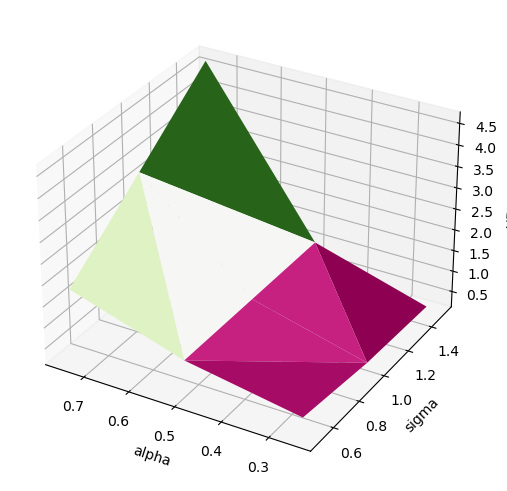

In [19]:
%matplotlib inline
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
x = q1_sol['alpha']
y = q1_sol['sigma']
hf_hm = q1_sol['HF/HM']
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('HF/HM')
ax.invert_xaxis()
ax.plot_trisurf(x,y, hf_hm, cmap='PiYG'); # create surface plot in the axis
# note: fig.add_subplot(a,b,c) creates the c'th subplot in a grid of a times b plots

**Question 2**


In [20]:

model = HouseholdSpecializationModelClass()

discrete_solution = model.solve_wF_vec(discrete=True)
df_discrete = {}
df_discrete['HF'] = discrete_solution.HF_vec
df_discrete['HM'] = discrete_solution.HM_vec
df_discrete['LF'] = discrete_solution.LF_vec
df_discrete['LM'] = discrete_solution.LM_vec


df_discrete = pd.DataFrame(df_discrete)
df_discrete['utility'] = model.calc_utility(df_discrete.LM, df_discrete.HM, df_discrete.LF, df_discrete.HF)
df_discrete['logHF/logHM'] = np.log(df_discrete['HF']) - np.log(df_discrete['HM'])
df_discrete['WF'] =  model.par.wF_vec.tolist()
df_discrete['WM'] = model.par.wM
df_discrete['logWF/logWM'] = np.log(df_discrete['WF']) - np.log(df_discrete['WM'])

df_discrete


,HF,HM,LF,LM,utility,logHF/logHM,WF,WM,logWF/logWM
0,5.0,4.0,3.0,6.0,-0.234618,0.223144,0.8,1.0,-0.223144
1,4.5,4.5,4.0,5.0,-0.231835,0.000000,0.9,1.0,-0.105361
2,4.5,4.5,4.5,4.5,-0.230822,0.000000,1.0,1.0,0.000000
3,4.0,4.5,5.0,4.0,-0.230151,-0.117783,1.1,1.0,0.095310
4,4.0,5.0,5.5,3.0,-0.229743,-0.223144,1.2,1.0,0.182322


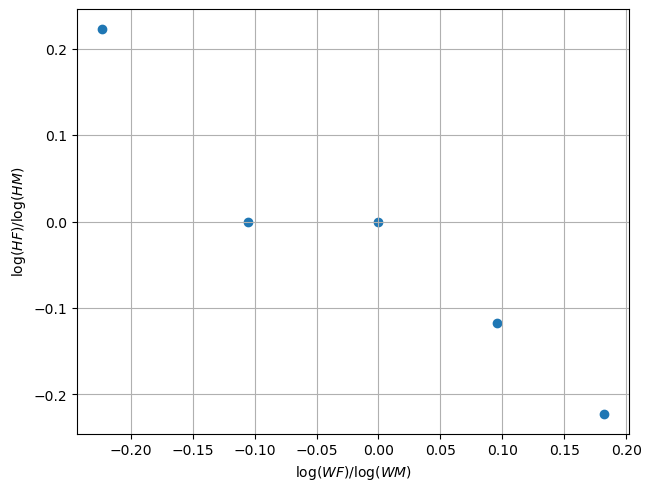

In [21]:
x = df_discrete['logWF/logWM']
y = df_discrete['logHF/logHM']

fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_ylabel('$\log (HF)/\log (HM)$')
ax.set_xlabel('$\log (WF)/\log (WM)$')
ax.scatter(x, y)

In [22]:
print(model.par.alpha, model.par.sigma)

0.5 1.0


**Question 3**

**3.1 solving the consumer problem using a loop**

In [23]:
model = HouseholdSpecializationModelClass()

solutions = {}
for i in ['HF', 'HM', 'LF', 'LM', 'WF', 'WM', 'Utility']:
    solutions[i] = []

model.par.alpha = 0.5
model.par.sigma = 1

for i in [0.8, 0.9, 1.0, 1.1, 1.2]:
    model.par.wF = i
    solution = model.solve()
    solutions['HF'].append(solution.HF)
    solutions['LF'].append(solution.LF)
    solutions['HM'].append(solution.HM)
    solutions['LM'].append(solution.LM)
    solutions['WF'].append(model.par.wF)
    solutions['WM'].append(model.par.wM)
    solutions['Utility'].append(solution.U)
    
#
df = pd.DataFrame(solutions)


In [24]:
df['logHF/logHM'] = np.log(df['HF']) - np.log(df['HM'])

df['logWF/logWM'] = np.log(df['WF']) - np.log(df['WM'])

df['alternative_utility'] = model.calc_utility(df.LM, df.HM, df.LF, df.HF)

df

,HF,HM,LF,LM,WF,WM,Utility,logHF/logHM,logWF/logWM,alternative_utility
0,5.115682,4.092552,2.869769,5.889265,0.8,1.0,-0.245107,2.231419e-01,-0.223144,-0.234728
1,4.745642,4.271060,3.749263,5.167731,0.9,1.0,-0.241881,1.053648e-01,-0.105361,-0.232210
2,4.454549,4.454549,4.454549,4.454549,1.0,1.0,-0.238110,2.220446e-16,0.000000,-0.230723
3,4.220018,4.642019,5.021907,3.759722,1.1,1.0,-0.234004,-9.531000e-02,0.095310,-0.229948
4,4.027190,4.832658,5.479626,3.089683,1.2,1.0,-0.229714,-1.823277e-01,0.182322,-0.229714


***Solving the problem using the function with the defined wf_VEC***

In [25]:
### solve model using WF_vec gives us the same result as running the loop above 
contionoussolution = model.solve_wF_vec(discrete=False)
df1 = {}
df1['HF'] = contionoussolution.HF_vec
df1['HM'] = contionoussolution.HM_vec
df1['LF'] = contionoussolution.LF_vec
df1['LM'] = contionoussolution.LM_vec

df1 = pd.DataFrame(df1)
df1['utility'] = model.calc_utility(df1.LM, df1.HM, df1.LF, df1.HF)

df1

,HF,HM,LF,LM,utility
0,5.115682,4.092552,2.869769,5.889265,-0.234728
1,4.745642,4.271060,3.749263,5.167731,-0.232210
2,4.454549,4.454549,4.454549,4.454549,-0.230723
3,4.220018,4.642019,5.021907,3.759722,-0.229948
4,4.027190,4.832658,5.479626,3.089683,-0.229714


[]

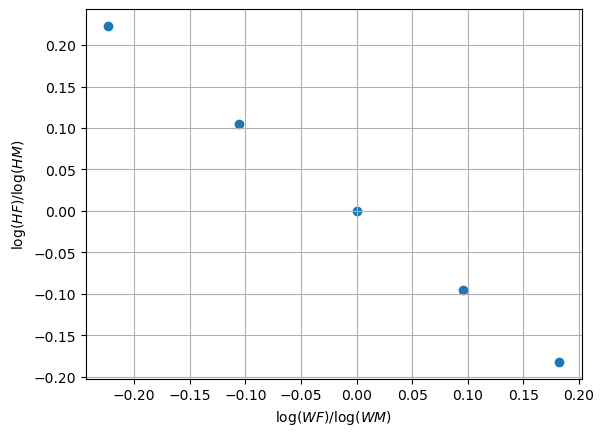

In [26]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df['logWF/logWM'], df['logHF/logHM'])
ax.grid()
ax.set_ylabel('$\log (HF)/\log (HM)$')
ax.set_xlabel('$\log (WF)/\log (WM)$')
ax.plot()

In [27]:
print(model)


 The baseline parameters in the model is: 
1. Preferences           = (rho, epsilon, omega, nu) = (2.00, 1.00, 0.50, 0.001) 
2. Household production  = (alpha, sigma )           = (0.50, 1.00) 
3. Wages                 = (wM,wF)                   = (1.00, 1.20) 



In [28]:
print(model.solve())

namespace(LM=3.0896833700863895, HM=4.832658369010341, LF=5.479626099532714, HF=4.027190409609517, U=-0.22971438227259638)


**Run regression**

$\log \frac{H_F}{H_M} = \beta_0 + \beta_1 \log \frac{w_F}{w_M} $

In [29]:
model = HouseholdSpecializationModelClass()
model.solve_wF_vec()

print(model)
model.run_regression()

print(f'beta0 = {model.sol.beta0:.3} and beta_1 = {model.sol.beta1:.3}')


 The baseline parameters in the model is: 
1. Preferences           = (rho, epsilon, omega, nu) = (2.00, 1.00, 0.50, 0.001) 
2. Household production  = (alpha, sigma )           = (0.50, 1.00) 
3. Wages                 = (wM,wF)                   = (1.00, 1.20) 

beta0 = -8.06e-07 and beta_1 = -1.0


**Estimate $\sigma$ and $\alpha$ such that $(\beta_{0}-\hat \beta_0)^2+(\beta_1-\hat \beta_1)^2$ is minimized, where we assume that $\beta_0=0.4$ and $\beta_1 \approx -0.1$**



In [133]:
beta0 = 0.4
beta1 = -0.1
def lossfunction(beta0hat, beta1hat, beta0=0.4, beta1=-0.1):
    return (beta0-beta0hat)**2 + (beta1-beta1hat)**2 

winners = {}
winners['alpha'] = []
winners['sigma'] = []
winners['loss'] = []

all = {}
all['alpha'] = []
all['sigma'] = []
all['loss'] = []

for model.par.alpha in tqdm(np.linspace(0,1, 100)):
    for model.par.sigma in np.linspace(0, 100, 100):
            sol = model.solve_wF_vec()
            model.run_regression()
            beta0hat = model.sol.beta0
            beta1hat = model.sol.beta1
            #print(f'beta0 = {model.sol.beta0:.3} and beta_1 = {model.sol.beta1:.3}')
            loss = lossfunction(beta0hat, beta1hat)
            all['alpha'].append(model.par.alpha)
            all['sigma'].append(model.par.sigma)
            all['loss'].append(loss) 
            #if -0.4 <= loss <= 0.4:
            #     winners['alpha'].append(model.par.alpha)
            #     winners['sigma'].append(model.par.sigma)
            #     winners['loss'].append(loss)

model.par.alpha = 0.5
model.par.sigma = 1


  0%|          | 0/100 [00:00<?, ?it/s]/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:231: RuntimeWarning: divide by zero encountered in log
  y = np.log(sol.HF_vec/sol.HM_vec)
 24%|██▍       | 24/100 [07:32<23:53, 18.86s/it]


KeyboardInterrupt: 

In [134]:
all = pd.DataFrame(all)

In [135]:
all.sort_values(by='loss')

,alpha,sigma,loss
0,0.000000,0.000000,0.17
500,0.050505,0.000000,0.17
600,0.060606,0.000000,0.17
700,0.070707,0.000000,0.17
800,0.080808,0.000000,0.17
...,...,...,...
2456,0.242424,56.565657,NaN
2457,0.242424,57.575758,NaN
2458,0.242424,58.585859,NaN
2459,0.242424,59.595960,NaN


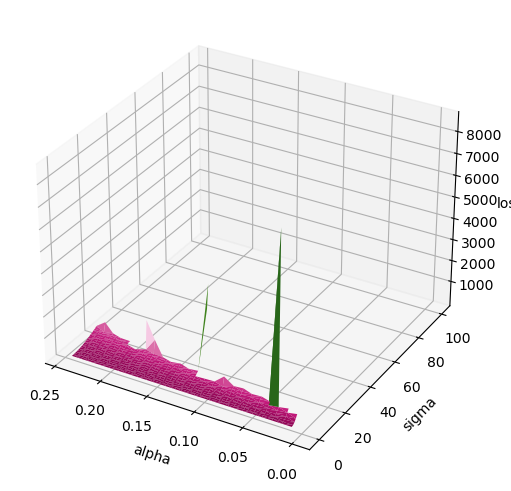

In [136]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
x = all['alpha']
y = all['sigma']
z = all['loss']
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('loss')
ax.invert_xaxis()
ax.plot_trisurf(x,y, z, cmap='PiYG'); # create surface plot in the axis
# note: fig.add_subplot(a,b,c) creates the c'th subplot in a grid of a times b pl

In [129]:
#all_no_nan = all.loc[(all['loss'].isnull()==False)&(all['sigma']<1)&(all['alpha']<1)&(all['loss']<100), :]
all_no_nan = all.loc[all['loss']<100, :]

In [2]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
x = all_no_nan['alpha']
y = all_no_nan['sigma']
z = all_no_nan['loss']
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('loss')
ax.plot_trisurf(x,y, z, cmap='Blues'); # create surface plot in the axis
# note: fig.add_subplot(a,b,c) creates the c'th subplot in a grid of a times b pl

NameError: name 'all_no_nan' is not defined

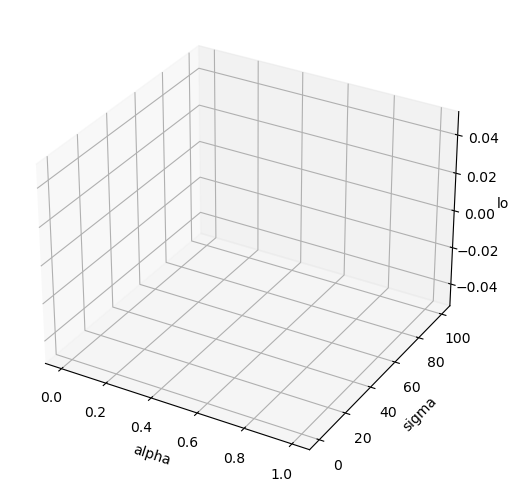

In [132]:

#df = all.loc[all['loss']<0.3]
df = all
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
x = df['alpha']
y = df['sigma']
z = df['loss']
x1 = np.linspace(df['alpha'].min(), df['alpha'].max(), len(df['alpha'].unique()))
y1 = np.linspace(df['sigma'].min(), df['sigma'].max(), len(df['sigma'].unique()))
x2, y2 = np.meshgrid(x1, y1)
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('loss')
z2 = griddata((df['alpha'], df['sigma']), df['loss'], (x2, y2), method='cubic')
ax.plot_surface(x2,y2, z2, cmap='coolwarm', rstride=1, cstride=1); # create surface plot in the axis
# note: fig.add_subplot(a,b,c) creates the c'th subplot in a grid of a times b pl

**Estimate like Jeppe Did in the ASAD lecture**

In [46]:
model = HouseholdSpecializationModelClass()

In [189]:


def obj(x, parnames, do_print=False):
      # a. update parameters
    for xval,parname in zip(x,parnames):
        par.__dict__[parname] = xval
        if do_print: print(f'{parname:10s} = {xval:.4f}')

    if do_print: print('')

    # b. simulate and calculate moments
    model.solve_wF_vec()
    model.run_regression()

    # c. compare with data
    error = model.loss_function()

    return error



**Calculate objective at initial values:**

In [198]:
par = model.par
model.par.alpha = 0.5
model.par.sigma = 0.8
parnames = ['alpha','sigma']

#x0 = [par.__dict__[parname] for parname in parnames]
x0 = [0.5, 0.7]
error_ = obj(x0,parnames,do_print=True)
print(error_)

alpha      = 0.5000
sigma      = 0.7000

0.3814121057393089


In [199]:
bounds = ((0,1),(0,100))
res = optimize.minimize(obj,x0,bounds=bounds,method='nelder-mead',args=(parnames))

In [196]:
assert res.success

In [200]:
error_ = obj(res.x, parnames, do_print=True)
print(error_)

alpha      = 0.9881
sigma      = 0.0911

5.998033018136862e-08


**Estimate with module in "HSM_model_copy.py"**

In [50]:
model = HouseholdSpecializationModelClass()
print(model.par.alpha, model.par.sigma)


0.5 1.0


In [70]:
model.par.alpha = 0.3
model.par.sigma = 0.3
error = model.estimate()

alpha      = 0.9820
sigma      = 0.1000



In [71]:
print(error)

1.4721427939566955e-09


**Question 4**

We estimate $\sigma$ and $\alpha$ such that the error function $(\beta_{0}-\hat \beta_0)^2+(\beta_1-\hat \beta_1)^2$ is minimized, where we assume that $\beta_0=0.4$ and $\beta_1 \approx -0.1$.

First we plot the error function for discrete values of $\alpha$ and $\sigma$ and secondly we minimize the loss function using the scipy module.


In [1]:
# required packages, modules and functions for quesiton 4:
%load_ext autoreload
%autoreload 2
from HSM_model_copy import HouseholdSpecializationModelClass
import numpy as np
import pandas as pd
from tqdm import tqdm
%matplotlib inline
%matplotlib qt
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.interpolate import griddata
import os
os.getcwd()

'/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject'

**4.1 plots**

Plotting the errors for different values of $\sigma$ and $\alpha$ restricting the values of the error function gradually, suggests that the estimates that reduce the loss function lies in a neighbourhood of $\alpha$ close to 1 and $\sigma$ close to zero.

In [42]:
model = HouseholdSpecializationModelClass()
results = {}
for i in ['alpha', 'sigma', 'error']:
      results[i] = []

for model.par.alpha in tqdm(np.linspace(0,1, 100)):
    for model.par.sigma in np.linspace(0, 100, 100):
            sol = model.solve_wF_vec()
            model.run_regression()
            #beta0hat = model.sol.beta0
            #beta1hat = model.sol.beta1
            error = model.error_function()
            results['alpha'].append(model.par.alpha)
            results['sigma'].append(model.par.sigma)
            results['error'].append(error) 

model.par.alpha = 0.5
model.par.sigma = 1


  0%|          | 0/100 [00:00<?, ?it/s]/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:231: RuntimeWarning: divide by zero encountered in log
  y = np.log(sol.HF_vec/sol.HM_vec)
  0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [29]:
results = pd.DataFrame(results)
results.sort_values(by='error')
results.to_pickle(os.path.join('output_from_loops','resultsbigloop.pkl'))

In [60]:
results = pd.read_pickle(os.path.join('output_from_loops','resultsbigloop.pkl'))
results.head()

,alpha,sigma,error
0,0.0,0.000000,0.17
1,0.0,1.010101,NaN
2,0.0,2.020202,NaN
3,0.0,3.030303,NaN
4,0.0,4.040404,NaN


In [85]:
error_cutoff = [10, 20, 100, 300, 400, 500]
for i in error_cutoff:
    df = results[results['error']<i]
    fig = plt.figure(constrained_layout=True)
    ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
    x = df['alpha']
    y = df['sigma']
    z = df['error']
    x1 = np.linspace(df['alpha'].min(), df['alpha'].max(), len(df['alpha'].unique()))
    y1 = np.linspace(df['sigma'].min(), df['sigma'].max(), len(df['sigma'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    ax.set_xlabel('alpha')
    ax.set_ylabel('sigma')
    ax.set_zlabel('error')
    ax.set_title(f'error restricted to less than {i}')
    z2 = griddata((df['alpha'], df['sigma']), df['error'], (x2, y2), method='nearest')
    ax.plot_surface(x2,y2, z2, cmap='coolwarm', rstride=1, cstride=1);

The above figures suggest that $\sigma$ should be at least less than 3. Plotting the eror function for $\sigma \in (0,3)$ can help set some starting values for the optimization problem.

In [48]:
results_sigma_low = {}
for i in ['alpha', 'sigma', 'error']:
      results_sigma_low[i] = []

for model.par.alpha in tqdm(np.linspace(0,1, 50)):
    for model.par.sigma in np.linspace(0, 3, 50):
            sol = model.solve_wF_vec()
            model.run_regression()
            #beta0hat = model.sol.beta0
            #beta1hat = model.sol.beta1
            error = model.error_function()
            results_sigma_low['alpha'].append(model.par.alpha)
            results_sigma_low['sigma'].append(model.par.sigma)
            results_sigma_low['error'].append(error) 

model.par.alpha = 0.5
model.par.sigma = 1

results_sigma_low = pd.DataFrame(results_sigma_low)
results_sigma_low.to_pickle(os.path.join('output_from_loops','results_sigma_low.pkl'))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1
/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1
/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:231: RuntimeWarning: divide by zero encountered in log
  y = np.log(sol.HF_vec/sol.HM_vec)
 98%|█████████▊| 49/50 [07:20<00:08,  8.50s/it]/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:231: RuntimeWarning: divide by zero encountered in divide
  y = np.log(sol.HF_vec/sol.HM_vec)
100%|██████████| 

In [86]:
results_sigma_low = pd.read_pickle(os.path.join('output_from_loops', 'results_sigma_low.pkl'))
for i in [0.1, 1, 2]:
    df = results_sigma_low[results_sigma_low['error']<i]
    fig = plt.figure(constrained_layout=True)
    ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
    x = df['alpha']
    y = df['sigma']
    z = df['error']
    x1 = np.linspace(df['alpha'].min(), df['alpha'].max(), len(df['alpha'].unique()))
    y1 = np.linspace(df['sigma'].min(), df['sigma'].max(), len(df['sigma'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    ax.set_xlabel('alpha')
    ax.set_ylabel('sigma')
    ax.set_zlabel('error')
    ax.set_title(f'error restricted to less than {i}')
    z2 = griddata((df['alpha'], df['sigma']), df['error'], (x2, y2), method='nearest')
    ax.plot_surface(x2,y2, z2, cmap='coolwarm', rstride=1, cstride=1);

The three figures above suggest that minimizing the error can be done choosing starting values for sigma and alpha close to 0 and above 0.5 respectively.

In [13]:
# solve for boptimal parameters usign scipy, 

model = HouseholdSpecializationModelClass()
print(model.par)



namespace(rho=2.0, nu=0.001, epsilon=1.0, omega=0.5, alpha=0.5, sigma=1.0, wM=1.0, wF=1.0, wF_vec=array([0.8, 0.9, 1. , 1.1, 1.2]), beta0_target=0.4, beta1_target=-0.1)


In [14]:
model.par.sigma = 0.1 #set starting value for optimisation problem for sigma to 0.1
model.par.alpha = 0.51 #set starting value for optimisation problem for alpha to 0.51
error = model.estimate()
print(error)

/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1
/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1


alpha      = 0.9820
sigma      = 0.1000

1.1058424840468663e-16


Using the parameter $\sigma=0.1$ and $\alpha=0.9820$ we minimize the error function. These results suggests that women have to seriously more productive than men in the household if we want the momdel to fit the data.

***Question 5***

In [25]:
model=HouseholdSpecializationModelClass()

In [26]:
sigma_opt, error = model.estimate_sigma()

In [28]:
print(f'sigma = {sigma_opt} and error = {error}')

sigma = 0.1000346216105285 and error = 0.15999927706757314


In [29]:
model=HouseholdSpecializationModelClass()

sigma_par_values = np.linspace(0, 0.2, 200)
results_alpha_fixed = {}
for i in ['alpha', 'sigma', 'error']:
    results_alpha_fixed[i] = []

for i in tqdm(sigma_par_values):
        model.par.sigma = i
        sol = model.solve_wF_vec()
        model.run_regression()
        #beta0hat = model.sol.beta0
        #beta1hat = model.sol.beta1
        error = model.error_function()        
        results_alpha_fixed['alpha'].append(model.par.alpha)
        results_alpha_fixed['sigma'].append(model.par.sigma)
        results_alpha_fixed['error'].append(error) 


  0%|          | 1/200 [00:00<01:12,  2.76it/s]/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1
/Users/carlsimpson/Documents/6. semester polit/Intro Prog/projects-2023-scb/inauguralproject/HSM_model_copy.py:76: RuntimeWarning: overflow encountered in double_scalars
  H = ((1-par.alpha)*HM**potens + par.alpha * HF**potens)**potens**-1
100%|██████████| 200/200 [00:37<00:00,  5.36it/s]


In [30]:
results_alpha_fixed = pd.DataFrame(results_alpha_fixed)

In [31]:
results_alpha_fixed.plot('sigma', 'error')

<AxesSubplot: xlabel='sigma'>